In [1]:
#| default_exp safe_ds

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
#| export 
import torch
import pandas as pd
import numpy as np
import fastcore.all as fc
import pytorch_lightning as pl

from pathlib import Path
from functools import partial
from typing import Union, List
from safetensors.numpy import load_file
from torchvision.transforms import Compose
from omegaconf import OmegaConf, ListConfig

from voxdet.utils import locate_cls

/tmp/ipykernel_4081557/3380558261.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
import fastcore.all as fc
from tqdm import tqdm
from safetensors.numpy import save_file

# from voxdet.tfsm.med import CropLung
from voxdet.tfsm.standard import StandardT
from voxdet.tfsm.voxt import RandPosCrop, Norm3d

In [19]:
files = list(fc.Path("/cache/fast_data_nas8/cache_3d/qct_det_cache_new/lidc_cache/").glob("*.safetensors"))
len(files), files[0]

(36,
 Path('/cache/fast_data_nas8/cache_3d/qct_det_cache_new/lidc_cache/1.3.6.1.4.1.14519.5.2.1.6279.6001.144883090372691745980459537053.safetensors'))

In [6]:
#tt = np.concatenate([load_file(file_name)["boxes"] for file_name in tqdm(files)])

In [20]:
%%time 
file_name = files[np.random.randint(len(files))]
fl = load_file(file_name)

CPU times: user 6.32 ms, sys: 91.3 ms, total: 97.6 ms
Wall time: 726 ms


In [21]:
file_name

Path('/cache/fast_data_nas8/cache_3d/qct_det_cache_new/lidc_cache/1.3.6.1.4.1.14519.5.2.1.6279.6001.144883090372691745980459537053.safetensors')

In [22]:
fl["boxes"]

array([[179.5,  93.5,  29.5, 193.5, 120.5,  67.5],
       [144.5,  82.5, 372.5, 146.5,  88.5, 378.5],
       [ 94.5, 212.5,  76.5,  96.5, 223.5,  92.5]])

## Visualize the nodules.

In [6]:
from voxdet.retina_test import convert2int, draw_on_ct
from qct_utils.ctvis.viewer import plot_scans

In [9]:
wrong_lung_seg_sids = ["1.3.6.1.4.1.14519.5.2.1.6279.6001.157537616155071783765339942952",
                 "1.3.6.1.4.1.14519.5.2.1.6279.6001.312704771348460502013249647868",
                 "1.3.6.1.4.1.14519.5.2.1.6279.6001.144883090372691745980459537053",
                 "1.3.6.1.4.1.14519.5.2.1.6279.6001.618434772073433276874225174904",
                 "1.3.6.1.4.1.14519.5.2.1.6279.6001.300246184547502297539521283806",
                 "1.3.6.1.4.1.14519.5.2.1.6279.6001.202283133206014258077705539227"]

In [10]:
# file_name = files[np.random.randint(len(files))]
file_name = f'/cache/shubham/lidc_cache/{wrong_lung_seg_sids[0]}.safetensors'
fl = load_file(file_name)
boxes = convert2int(fl["boxes"])
img = fl["images"]
boxes

array([[ 54, 232, 328,  58, 244, 340],
       [ 43, 219, 254,  49, 254, 272],
       [ 34, 182, 172,  38, 190, 181],
       [ 27, 234, 272,  31, 244, 280],
       [ 21, 222,  89,  25, 235, 102]])

In [11]:
file_name

'/cache/shubham/lidc_cache/1.3.6.1.4.1.14519.5.2.1.6279.6001.157537616155071783765339942952.safetensors'

In [43]:
# for file in tqdm(files):
#     fl = load_file(file_name)
#     boxes = convert2int(fl["boxes"])
#     if np.any(boxes<0): breakpoint()

In [50]:
lung_mask = np.load(f"/cache/fast_data_nas8/qct/shubham/lidc_lung_sep_safetensors/lung_mask_cache/{wrong_lung_seg}_lung_mask.npy")


In [51]:
lung_mask.shape

(240, 512, 512)

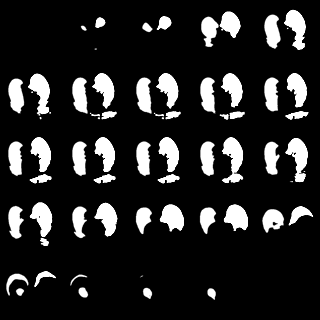

In [58]:
from voxdet.utils import vis, hu_to_lung_window

vis(lung_mask*255, size=64, window=False)

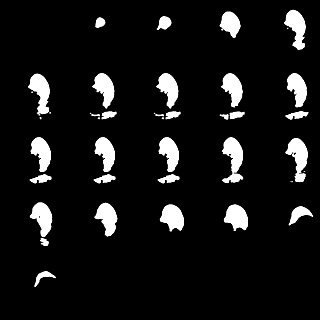

In [59]:
left_lung = lung_mask.copy()
left_lung[left_lung == 1] = 0
vis(left_lung*255, size=64, window=False)

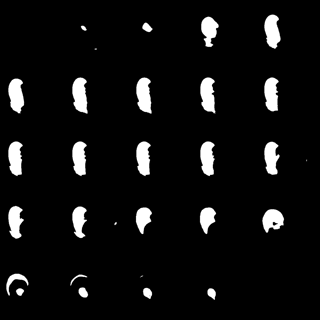

In [60]:
right_lung = lung_mask.copy()
right_lung[right_lung == 2] = 0
vis(right_lung*255, size=64, window=False)

In [61]:
dimg = draw_on_ct(img, boxes)

In [62]:
plot_scans([dimg, img], ["scan", "raw"])

interactive(children=(RadioButtons(description='Slice plane selection:', index=2, options=('y-z', 'z-x', 'x-y'…

In [21]:
fc.L([i.name[:-7] for i in fc.L(Path("/qct_cache/").glob("*.safetensors"))])

(#0) []

In [22]:
#| export
def get_scan_ids_inside_folder(folder_path: Union[str, List[str]], ext: str=".nii.gz"):
    def _run(folder): return fc.L([i.name[:-7] for i in fc.L(Path(folder).glob(f"*{ext}"))])
    return _run(folder_path) if isinstance(folder_path, str) else [j for i in folder_path for j in _run(i)]

In [23]:
get_scan_ids_inside_folder("/qct_cache", ext=".safetensors")

(#0) []

In [24]:
#| export 
def get_scan_ids_from_txt(file_path: str):
    files = [i.split()[0] for i in open(file_path, "r")]
    return files

In [25]:
#| hide
scans = get_scan_ids_from_txt("/home/users/vanapalli.prakash/foundations/qct_nodule_detection/deps/qct_data/annotations/stratified_splits/lidc/train.txt")
len(scans), scans[0]

(1040, '1.3.6.1.4.1.14519.5.2.1.6279.6001.190188259083742759886805142125')

In [26]:
fc.L([i.name[:-12] for i in fc.L(Path("/qct_cache").glob("*.safetensors"))])

(#0) []

In [27]:
#| export
def get_scan_ids_inside_folder(folder_path: Union[str, List[str]], ext: str=".nii.gz"):
    def _run(folder): 
        if ext == '.safetensors':
            return fc.L([i.name[:-12] for i in fc.L(Path(folder).glob(f"*{ext}"))])
        if ext == ".nii.gz":
            return fc.L([i.name[:-7] for i in fc.L(Path(folder).glob(f"*{ext}"))])
        else:
            raise NotImplementedError
    return _run(folder_path) if isinstance(folder_path, str) else [j for i in folder_path for j in _run(i)]

In [28]:
get_scan_ids_inside_folder("//cache/fast_data_nas8/cache_3d/qct_det_cache_new/lidc_cache/folds_0", ext=".safetensors")

(#531) ['1.3.6.1.4.1.14519.5.2.1.6279.6001.157537616155071783765339942952_left','1.3.6.1.4.1.14519.5.2.1.6279.6001.143813757344903170810482790787','1.3.6.1.4.1.14519.5.2.1.6279.6001.226383054119800793308721198594_right','1.3.6.1.4.1.14519.5.2.1.6279.6001.428038562098395445838061018440_right','1.3.6.1.4.1.14519.5.2.1.6279.6001.340202188094259402036602717327_left','1.3.6.1.4.1.14519.5.2.1.6279.6001.244447966386688625240438849169_right','1.3.6.1.4.1.14519.5.2.1.6279.6001.259124675432205040899951626253','1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243_left','1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720','1.3.6.1.4.1.14519.5.2.1.6279.6001.406508755509460310384282367044_right'...]

In [29]:
import pandas as pd
pd.read_csv(fc.Path("../studies/only_lidc/folds1/folds_0.csv"))["scans"]

0      1.3.6.1.4.1.14519.5.2.1.6279.6001.170765551637...
1      1.3.6.1.4.1.14519.5.2.1.6279.6001.340202188094...
2      1.3.6.1.4.1.14519.5.2.1.6279.6001.149463915556...
3      1.3.6.1.4.1.14519.5.2.1.6279.6001.286524966129...
4      1.3.6.1.4.1.14519.5.2.1.6279.6001.797637294244...
                             ...                        
172    1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786...
173    1.3.6.1.4.1.14519.5.2.1.6279.6001.173556680294...
174    1.3.6.1.4.1.14519.5.2.1.6279.6001.323753921818...
175    1.3.6.1.4.1.14519.5.2.1.6279.6001.240630002689...
176    1.3.6.1.4.1.14519.5.2.1.6279.6001.141174904898...
Name: scans, Length: 177, dtype: object

In [9]:
#| export 
class SafeTensorsDS(torch.utils.data.Dataset):
    def __init__(self, root: Union[str, List[str]], include: Union[str, List[str]]=None, individual_lung: bool = False):
        super().__init__()
        self.root = root
        # self.transforms = Compose(transforms) if transforms is not None else transforms
        if not individual_lung : 
            self.imgs = list(Path(root).glob("*.safetensors")) if isinstance(self.root, str) else \
            [j for i in self.root for j in list(Path(i).glob("*.safetensors"))]
        else :
            self.imgs = list(Path(root).glob("*left.safetensors")) + list(Path(root).glob("*right.safetensors"))  if isinstance(self.root, str) else \
            [j for i in self.root for j in list(Path(i).glob("*left.safetensors"))] + [j for i in self.root for j in list(Path(i).glob("*right.safetensors"))]

        if include is not None:
            if isinstance(include, list):
                
                if fc.Path(include[0]).suffix ==".csv":
                    series_ids = fc.L([j for i in include for j in pd.read_csv(i)["scans"].values])
                if fc.Path(include[0]).suffix ==".txt":
                    series_ids = fc.L([j for i in include for j in get_scan_ids_from_txt(i)])
            elif isinstance(include, str):
                series_ids = get_scan_ids_from_txt(include) if ".txt" in include else get_scan_ids_inside_folder(include)

            if individual_lung:
                series_ids = [s + suffix for s in series_ids for suffix in ["_left", "_right"]]

            self.imgs = [i for i in self.imgs if i.stem in series_ids]

        print(f"total images: {len(self.imgs)}")
        if len(self.imgs)==0: raise ValueError(f"there are no images with `.safetensors` as extensions in {self.root}")
        
    def __getitem__(self, idx):
        fl = load_file(self.imgs[idx])
        fl["series_id"] = self.imgs[idx].stem
        # if self.transforms is not None: fl = self.transforms(fl)
        return fl
    
    def __len__(self): return len(self.imgs)

In [31]:
#ds = SafeTensorsDS(root=[f"/home/users/vanapalli.prakash/lidc3/folds_{i}" for i in range(4)])
#train_txt = "/home/users/vanapalli.prakash/foundations/qct_nodule_detection/deps/qct_data/annotations/stratified_splits/lidc/train.txt"
train_txt = [i for i in fc.Path("../studies/only_lidc/folds1/").glob("*.csv")]
train_txt

train_txt = [fc.Path(f"../studies/only_lidc/folds1/folds_{i}") for i in range(4)]
train_txt

# ds = SafeTensorsDS(root="/qct_cache/lidc_cache_qct/", include=train_txt)
# len(ds)

[Path('../studies/only_lidc/folds1/folds_0'),
 Path('../studies/only_lidc/folds1/folds_1'),
 Path('../studies/only_lidc/folds1/folds_2'),
 Path('../studies/only_lidc/folds1/folds_3')]

In [32]:
%time fl = ds[0]

NameError: name 'ds' is not defined

In [33]:
from voxdet.tfsm.erase import RandomErase
from voxdet.tfsm.flip import RandFlip
from voxdet.tfsm.mip import MIP

In [28]:
tt =  [#StandardT(src_mode="yxzhwd", img_src_mode="zyx"), 
       #CropLung(model_ckpt="../resources/unet_r231-d5d2fc3d_v0.0.1.pth"),
       Norm3d(a_min =  -1024.0, a_max = 300.0, b_min = 0.0, b_max= 1.0, clip= True),
       MIP(num_slices=5, stride=1, mode="max", return_stacked_img=True),
       RandPosCrop(crop_size=(92, 192, 192)), 
       RandomErase(patch_size=(8, 16, 16), use_bbox=True, mask_perc=0.1, mask_filler="zeros", p=0.2),
       RandFlip(axis=[1, 2], p=[0.2, 0.2])
      ]
tt = Compose(tt)

In [29]:
%time ft = tt(fl)

CPU times: user 230 ms, sys: 808 ms, total: 1.04 s
Wall time: 1.05 s


In [12]:
#| export 
from copy import deepcopy
class MyCollateFn:
    def __init__(self, transform , train):
        self.transform = transform
        self.train = train
    
    def __call__(self, batch):
        # Apply transformation to each item in the batch if needed

        transform = deepcopy(self.transform)
        if self.train :
            transform[4].crop_size_index = np.random.choice(len(transform[4].crop_size))
        transform = Compose(transform) if transform is not None else transform
        batch = [transform(item) for item in batch]
    
        series_id = []
        images = []
        for i in batch :
            if isinstance(i["images"] , list) :
                series_id.append([i["series_id"]]*len(i["images"]))
                images.extend(i["images"])
            else :
                series_id.append(i["series_id"])
                images.append(i["images"])
    
        images = [torch.Tensor(i.astype(np.float32)).unsqueeze(0) if len(i.shape) == 3 else torch.Tensor(i.astype(np.float32)) for i in images]
        if self.train: images = torch.cat([i.unsqueeze(0) for i in images])  
    
        boxes = []
        for i in batch :
            if isinstance(i["boxes"] , list) :
                boxes.extend(i["boxes"])
            else :
                boxes.append(i["boxes"])
    
        labels = []
        for i in range(len(boxes)) :
            labels.append(np.zeros(boxes[i].shape[0]))
    
        boxes = [torch.Tensor(b.astype(np.float32)) for b in boxes]
        labels = [torch.Tensor(l.astype(np.float32)) for l in labels]

        return images, boxes, labels, series_id


In [ ]:
# #| export 
# collate_safetensors_train = MyCollateFn(transform=train_transform, train= True)
# collate_safetensors_train = MyCollateFn(transform=val_transform, train= False)

In [31]:
# #| export 
# collate_safetensors_train = partial(collate_safetensors, train=True)
# collate_safetensors_val = partial(collate_safetensors, train=False)

In [33]:
train_txt = [i for i in fc.Path("/home/users/vanapalli.prakash/foundations/qct_nodule_detection/studies/only_lidc/folds1/").glob("*.csv")]
ds = SafeTensorsDS(root="/qct_cache/lidc_cache_qct/", include=train_txt, transforms=tt.transforms)
len(ds)

total images: 1017


1017

In [34]:
dl = torch.utils.data.DataLoader(ds, batch_size=16, shuffle=True, num_workers=16, collate_fn=collate_safetensors)

In [ ]:
%time for d in tqdm(dl): break 


  0%|                                                                                                                         | 0/35 [00:00<?, ?it/s]

In [61]:
d[0].shape

torch.Size([12, 1, 92, 192, 192])

In [34]:
#dl = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True, num_workers=8, collate_fn=collate_safetensors)

In [35]:
#%time for d in tqdm(dl): pass 

In [36]:
#dl = torch.utils.data.DataLoader(ds, batch_size=12, shuffle=True, num_workers=12, collate_fn=collate_safetensors)

In [37]:
#%time for d in tqdm(dl): pass 

In [38]:
#dl = torch.utils.data.DataLoader(ds, batch_size=16, shuffle=True, num_workers=8, collate_fn=collate_safetensors)

In [39]:
#%time for d in tqdm(dl): pass 

## Lightning DataModule

In [41]:
resolution = (1.0, 1.0, 1.0)
roi_size = (96, 192, 192)
train_transforms = [
    dict(
        __class_fullname__="voxdet.tfsm.voxt.RandPosCrop",
        crop_size=roi_size, # removed multi_view argument from here; decision is made inside the RandPosCrop class itself.
    ),
    dict(
        __class_fullname__="voxdet.tfsm.erase.RandomErase",
        patch_size=(8, 16, 16),
        use_bbox=True,
        mask_perc=0.1, # %age of patches selected from the nodule crop
        mask_filler="zeros",
        p=0.2 # prob of applying tfsm
    ),
    dict(
        __class_fullname__="voxdet.tfsm.flip.RandFlip",
        axis=[1, 2], # (axis_dim, axis): (0, depth), (1, horizontal), (2, vertical); list of axes determines order in which flip tfsms are applied
        p=[0.2, 0.2] # prob of applying respective flip tfsms
    ),
]


train_data = dict(
  ds_paths="/qct_cache/lidc_cache_qct/",
  transform=train_transforms,
  dl = dict(
    batch_size=8, 
    num_workers=8, 
    shuffle=True,
    pin_memory=False
))

In [42]:
from omegaconf import OmegaConf
conf = OmegaConf.create()
conf.update(train_data)

In [43]:
locate_cls(conf.transform[0])

voxdet.tfsm.voxt.RandPosCrop(crop_size=[96, 192, 192])

In [44]:
"include" in conf.keys()

False

In [37]:
#| export 
class SafeTensorDL(pl.LightningDataModule):
    def __init__(self, ts: dict, vs: dict=None): 
        super().__init__(); fc.store_attr();
        self.tds = self.load_ds(self.ts)
        self.vds = self.load_ds(self.vs)

        # train_transforms =  [i for i in self.ts.transform]
        # val_transforms =  [i for i in self.vs.transform]

        self.collate_safetensors_train = MyCollateFn(transform=self.ts.transform, train= True)
        self.collate_safetensors_val = MyCollateFn(transform=self.vs.transform, train= False)
        
        #if self.vs is not None:
        #    vs_include = self.vs["include"] if "include" in self.vs.keys() else None
        #    self.vds = SafeTensorsDS(vs.ds_paths, [locate_cls(i) for i in self.vs.transform], include=vs_include)
    def load_ds(self, ts):
        ts_dspaths = ts["ds_paths"] if "ds_paths" in ts.keys() else None
        if isinstance(ts_dspaths, ListConfig):
            ts_dspaths = OmegaConf.to_container(ts_dspaths, resolve=True)
        
        ts_include = ts["include"] if "include" in ts.keys() else None
        if isinstance(ts_include, ListConfig):
            ts_include = OmegaConf.to_container(ts_include, resolve=True)

        if isinstance(ts_dspaths, str):
            tds = SafeTensorsDS(ts_dspaths, include=ts_include, individual_lung = ts.individual_lung)
        elif isinstance(ts_dspaths, list):
            assert len(ts_dspaths) == len(ts_include), "both ds_paths and ts include should be of same size and shape"
            tds = torch.utils.data.ConcatDataset([SafeTensorsDS(k, include=[v], individual_lung = w) for k, v , w in zip(ts_dspaths, ts_include, ts.individual_lung)])
        else:
            raise NotImplementedError 
        return tds

    def train_dl(self): return torch.utils.data.DataLoader(self.tds, collate_fn=self.collate_safetensors_train, **self.ts.dl)
    def val_dl(self):  return torch.utils.data.DataLoader(self.vds, collate_fn=self.collate_safetensors_val, **self.vs.dl) 


In [ ]:
#| notest
dl = SafeTensorDL(conf)

In [ ]:
%time for batch in dl.train_dl(): break

In [ ]:
batch[0].shape

In [ ]:
batch[1]

In [ ]:
batch[2]

In [ ]:
#%time for d in tqdm(dl.train_dl()): pass 

In [ ]:
# #| export 
# class SafeTensorTestDL(pl.LightningDataModule):
#     def __init__(self, ts: dict): 
#         super().__init__(); fc.store_attr();
#         self.tds = self.load_ds(self.ts)
        
#     def load_ds(self, ts):
#         ts_dspaths = ts["ds_paths"] if "ds_paths" in ts.keys() else None
#         if isinstance(ts_dspaths, ListConfig):
#             ts_dspaths = OmegaConf.to_container(ts_dspaths, resolve=True)
        
#         ts_include = ts["include"] if "include" in ts.keys() else None
#         if isinstance(ts_include, ListConfig):
#             ts_include = OmegaConf.to_container(ts_include, resolve=True)
            
#         if isinstance(ts_dspaths, str):
#             tds = SafeTensorsDS(ts_dspaths, [i for i in ts.transform], include=ts_include, individual_lung = ts.individual_lung)
#         elif isinstance(ts_dspaths, list):
#             assert len(ts_dspaths) == len(ts_include), "both ds_paths and ts include should be of same size and shape"
#             tds = torch.utils.data.ConcatDataset([SafeTensorsDS(k, [i for i in ts.transform], include=[v], individual_lung = w) for k, v , w in zip(ts_dspaths, ts_include, ts.individual_lung)])
#         else:
#             raise NotImplementedError 
#         return tds
       
#     def test_dl(self):  return torch.utils.data.DataLoader(self.tds, collate_fn=collate_safetensors_val, **self.ts.dl)
        

In [47]:
#| hide
import nbdev; nbdev.nbdev_export()